In [1]:
from datasets import coin_loader
import nodeshift

In [1]:
coins = coin_loader.parse_daily_graphs('datasets/stablecoin/coin_edgelistv3.csv')

maximum time stamp is 215


In [ ]:
pyg_mag = nodeshift.pyg_from_networkx_list(coins)

IOStream.flush timed out


In [2]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
"""
#EXECUTE THIS CELL TO RETRAIN ALL
results = nodeshift.encode_over_time(pyg_mag, device, folder='node-embeddings/stablecoin')

import pickle

with open('stablecoin_avgpr_results','wb') as fp:
    pickle.dump(results, fp)
"""

In [3]:
import pickle
with open('stablecoin_avgpr_results','rb') as fp:
    results = pickle.load(fp)

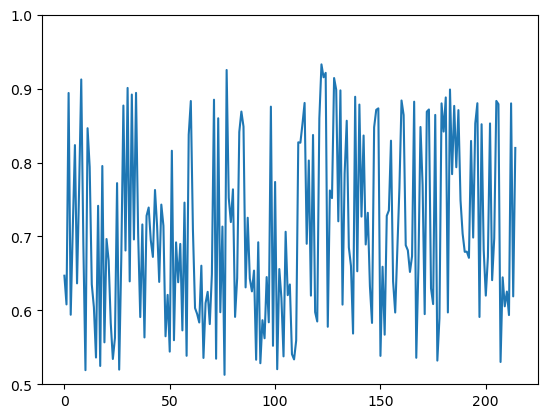

In [4]:
import matplotlib.pyplot as plt

plt.plot(range(len(results)),results)
plt.ylim(0.5,1)
plt.show()

In [5]:
embeddings_snap = []
for t in range(181):
    embeddings = torch.load(f'node-embeddings/stablecoin/{t}_embeddings.pt')
    embeddings_snap.append(embeddings)

In [6]:
activities = nodeshift.get_activity_vectors(embeddings_snap)

In [32]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
anomaly_scores = []
window = 3
for t in range(0,1):
    anomaly_scores.append(0)
for t in range(1,len(activities)):
    previous = np.mean(activities[t-window if t-window>=0 else 0:t],axis=0)
    current = activities[t]
    cosine_sim = nodeshift.cosine_sim(current, previous)
    anomaly = 1-nodeshift.cosine_sim(current, previous) if cosine_sim >=0 else abs(cosine_sim)
    anomaly_scores.append(anomaly)

final_scores = []
for t in range(len(anomaly_scores)):
    if t <= window: 
        final_scores.append(0)
    else:
        final_scores.append(max(0,anomaly_scores[t]-sum(anomaly_scores[t-window:t])))
        #final_scores.append(max(0,anomaly_scores[t]-anomaly_scores[t-1]))

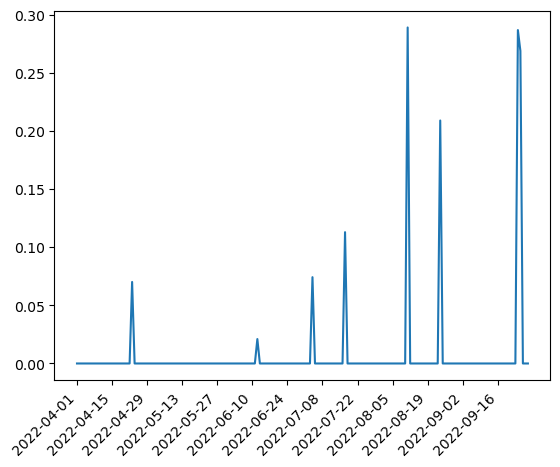

In [33]:
#[str(coin_loader.date_in_range(x[0]).date()) for x in [(k,v) for k,v in enumerate(final_scores) if v > np.quantile(final_scores, [0.9])]]
dates = [coin_loader.date_in_range(i) for i in range(len(final_scores))]
plt.plot(dates, final_scores)
plt.xticks(dates[::14], rotation=45, ha="right")
plt.show()

In [34]:
trends = [1 for i in range(0,coin_loader.days_from_april_1('06-05-22'))] +\
        [0 for i in range(coin_loader.days_from_april_1('06-05-22'), coin_loader.days_from_april_1('26-05-22'))]+\
        [1 for i in range(coin_loader.days_from_april_1('26-05-22'), coin_loader.days_from_april_1('10-06-22'))]+\
        [0 for i in range(2)] +\
        [1 for i in range(coin_loader.days_from_april_1('12-06-22'), coin_loader.days_from_april_1('07-08-22'))] +\
        [0 for i in range(coin_loader.days_from_april_1('07-08-22'), coin_loader.days_from_april_1('30-08-22'))] +\
        [1,1] + [0,0,0] + [1] + [0,0,0] + [1,1] + [0] + [1] +\
        [0 for i in range(coin_loader.days_from_april_1('12-09-22'), coin_loader.days_from_april_1('27-09-22'))]+\
        [1 for i in range(coin_loader.days_from_april_1('27-09-22'), 181)]

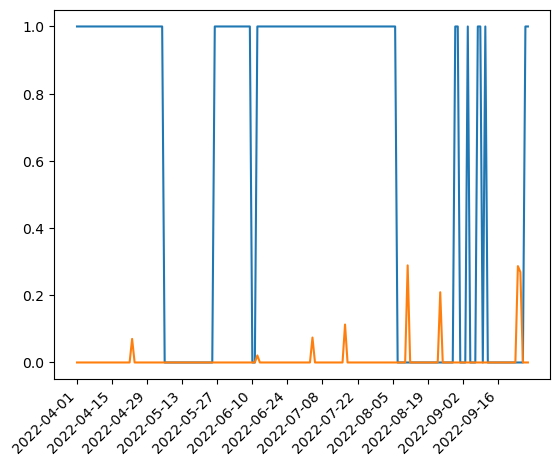

In [36]:
plt.plot(dates,trends)
plt.xticks(dates[::14], rotation=45, ha="right")
plt.plot(dates,final_scores)
plt.show()